In [ ]:
!pip install autogluon --quiet


In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("Mahadih534/Global_Environment-Social-And-Governance-Data")
df = dataset['train'].to_pandas()

# Filter for Mongolia only
df_mng = df[df["Country Name"]=="Mongolia"]

print(df_mng[["Indicator Name","Indicator Code"]].drop_duplicates().head(20))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/846 [00:00<?, ?B/s]

ESGCSV.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/16969 [00:00<?, ? examples/s]

                                          Indicator Name     Indicator Code
11431  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS
11432            Access to electricity (% of population)     EG.ELC.ACCS.ZS
11433  Adjusted savings: natural resources depletion ...  NY.ADJ.DRES.GN.ZS
11434  Adjusted savings: net forest depletion (% of GNI)  NY.ADJ.DFOR.GN.ZS
11435                 Agricultural land (% of land area)     AG.LND.AGRI.ZS
11436  Agriculture, forestry, and fishing, value adde...     NV.AGR.TOTL.ZS
11437  Annual freshwater withdrawals, total (% of int...     ER.H2O.FWTL.ZS
11438  Annualized average growth rate in per capita r...     SI.SPR.PCAP.ZG
11439  Cause of death, by communicable diseases and m...     SH.DTH.COMM.ZS
11440  Children in employment, total (% of children a...     SL.TLF.0714.ZS
11441             CO2 emissions (metric tons per capita)     EN.ATM.CO2E.PC
11442                                 Coastal protection     EN.CLC.CSTP.ZS
11443       

In [ ]:
# Filter for renewable share + energy intensity
codes = ["EG.FEC.RNEW.ZS","EG.EGY.PRIM.PP.KD"]
mng_indicators = df_mng[df_mng["Indicator Code"].isin(codes)]


In [ ]:
# All year columns
year_cols = [c for c in mng_indicators.columns if c.isdigit()]

mng_long = mng_indicators.melt(
    id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
    value_vars=year_cols,
    var_name="Year",
    value_name="Value"
)

mng_long["Year"] = mng_long["Year"].astype(int)
mng_long = mng_long.dropna(subset=["Value"])
print(mng_long.head())


   Country Name Country Code  \
61     Mongolia          MNG   
63     Mongolia          MNG   
65     Mongolia          MNG   
67     Mongolia          MNG   
69     Mongolia          MNG   

                                       Indicator Name  Indicator Code  Year  \
61  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1990   
63  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1991   
65  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1992   
67  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1993   
69  Renewable energy consumption (% of total final...  EG.FEC.RNEW.ZS  1994   

    Value  
61   1.89  
63   1.97  
65   2.40  
67   2.67  
69   3.04  


In [ ]:
ts = mng_long.pivot(index="Year", columns="Indicator Code", values="Value")
ts.rename(columns={
    "EG.FEC.RNEW.ZS":"RenewableShare",
    "EG.EGY.PRIM.PP.KD":"EnergyIntensity"
}, inplace=True)

ts = ts.sort_index()
print(ts.head())


Indicator Code  EnergyIntensity  RenewableShare
Year                                           
1990                        NaN            1.89
1991                        NaN            1.97
1992                        NaN            2.40
1993                        NaN            2.67
1994                        NaN            3.04


In [ ]:
print(ts.isna().sum())
print(ts.head(15))   # see where the gaps are


Indicator Code
EnergyIntensity    10
RenewableShare      0
dtype: int64
Indicator Code  EnergyIntensity  RenewableShare
Year                                           
1990                        NaN            1.89
1991                        NaN            1.97
1992                        NaN            2.40
1993                        NaN            2.67
1994                        NaN            3.04
1995                        NaN            3.01
1996                        NaN            3.44
1997                        NaN            3.39
1998                        NaN            3.74
1999                        NaN            3.59
2000                       9.25            5.73
2001                       9.06            6.09
2002                       9.26            6.51
2003                       8.45            6.09
2004                       7.87            5.76


In [ ]:
ts_interp = ts.interpolate(method="linear")


In [ ]:
ts_interp = ts_interp.fillna(method="bfill").fillna(method="ffill")


/tmp/ipython-input-1259654024.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts_interp = ts_interp.fillna(method="bfill").fillna(method="ffill")


Indicator Code
EnergyIntensity    0
RenewableShare     0
dtype: int64


<Axes: title={'center': 'Mongolia Energy Indicators'}, xlabel='Year'>

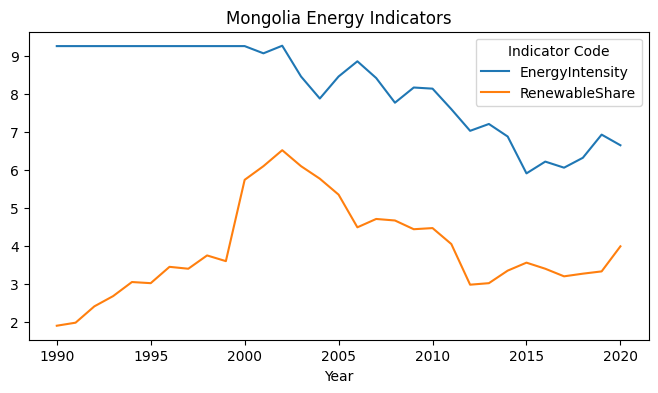

In [ ]:
print(ts_interp.isna().sum())
ts_interp.plot(title="Mongolia Energy Indicators", figsize=(8,4))


In [ ]:
!pip install autogluon --quiet

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.8.0+cu126 requires torch==2.8.0, but you have torch 2.7.1 which is incompatible.


In [ ]:
# Renewable energy share
renewable = ts_interp[['RenewableShare']].reset_index()
renewable['item_id'] = 'RenewableShare'
renewable.rename(columns={'Year':'timestamp','RenewableShare':'target'}, inplace=True)

# Energy intensity
intensity = ts_interp[['EnergyIntensity']].reset_index()
intensity['item_id'] = 'EnergyIntensity'
intensity.rename(columns={'Year':'timestamp','EnergyIntensity':'target'}, inplace=True)

# Combine
long_df = pd.concat([renewable, intensity], ignore_index=True)

ts_df = TimeSeriesDataFrame.from_data_frame(
    long_df,
    id_column='item_id',
    timestamp_column='timestamp'
)

print(ts_df.head())


Indicator Code                                target
item_id        timestamp                            
RenewableShare 1970-01-01 00:00:00.000001990    1.89
               1970-01-01 00:00:00.000001991    1.97
               1970-01-01 00:00:00.000001992    2.40
               1970-01-01 00:00:00.000001993    2.67
               1970-01-01 00:00:00.000001994    3.04


In [ ]:
train_data, test_data = ts_df.train_test_split(prediction_length=5)


Sorting the dataframe index before generating the train/test split.


In [ ]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor(
    prediction_length=5,
    target="target",
    eval_metric="RMSE",
    path="ag_ts_output_v2",   # new path so it doesn’t clash
    verbosity=2
)

predictor.fit(
    train_data,
    hyperparameters={
        "ARIMA": {},
        "ETS": {},
        "DirectTabular": {}  # ML-style predictor
    }
)


Beginning AutoGluon training...
AutoGluon will save models to '/content/ag_ts_output_v2'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.36 GB / 12.67 GB (89.6%)
Disk Space Avail:   62.46 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'ARIMA': {}, 'DirectTabular': {}, 'ETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 5,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'ns'
Provided train_data has 52 rows, 2 time series. Median time series length

In [ ]:
# Get leaderboard and derive RMSE from score_test (it's negated)
lb = predictor.leaderboard(test_data, silent=True)

summary = lb[['model','score_test']].copy()
summary['RMSE'] = -summary['score_test']   # flip sign to get actual RMSE
summary = summary[['model','RMSE']].sort_values('RMSE')

print(summary)
summary.to_csv("model_comparison_rmse.csv", index=False)


Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


              model      RMSE
0               ETS  0.484898
1  WeightedEnsemble  0.518818
2             ARIMA  0.518818
3     DirectTabular  1.521062


In [ ]:
forecasts = predictor.predict(ts_df)
print(forecasts.head())


Model not specified in predict, will default to the model with the best validation score: ARIMA


                                                  mean       0.1       0.2  \
item_id        timestamp                                                     
RenewableShare 1970-01-01 00:00:00.000002021  4.098551  3.390395  3.633491   
               1970-01-01 00:00:00.000002022  4.164138  3.071963  3.446885   
               1970-01-01 00:00:00.000002023  4.200424  2.785389  3.271142   
               1970-01-01 00:00:00.000002024  4.220498  2.523104  3.105785   
               1970-01-01 00:00:00.000002025  4.231604  2.282358  2.951495   

                                                   0.3       0.4       0.5  \
item_id        timestamp                                                     
RenewableShare 1970-01-01 00:00:00.000002021  3.808779  3.958557  4.098551   
               1970-01-01 00:00:00.000002022  3.717229  3.948229  4.164138   
               1970-01-01 00:00:00.000002023  3.621403  3.920689  4.200424   
               1970-01-01 00:00:00.000002024  3.525939  3.88494

In [ ]:
hist_df = ts_df.reset_index()
fc_df   = forecasts.reset_index()

print(hist_df.head())
print(fc_df.head())


Indicator Code         item_id                     timestamp  target
0               RenewableShare 1970-01-01 00:00:00.000001990    1.89
1               RenewableShare 1970-01-01 00:00:00.000001991    1.97
2               RenewableShare 1970-01-01 00:00:00.000001992    2.40
3               RenewableShare 1970-01-01 00:00:00.000001993    2.67
4               RenewableShare 1970-01-01 00:00:00.000001994    3.04
          item_id                     timestamp      mean       0.1       0.2  \
0  RenewableShare 1970-01-01 00:00:00.000002021  4.098551  3.390395  3.633491   
1  RenewableShare 1970-01-01 00:00:00.000002022  4.164138  3.071963  3.446885   
2  RenewableShare 1970-01-01 00:00:00.000002023  4.200424  2.785389  3.271142   
3  RenewableShare 1970-01-01 00:00:00.000002024  4.220498  2.523104  3.105785   
4  RenewableShare 1970-01-01 00:00:00.000002025  4.231604  2.282358  2.951495   

        0.3       0.4       0.5       0.6       0.7       0.8       0.9  
0  3.808779  3.958557  4.

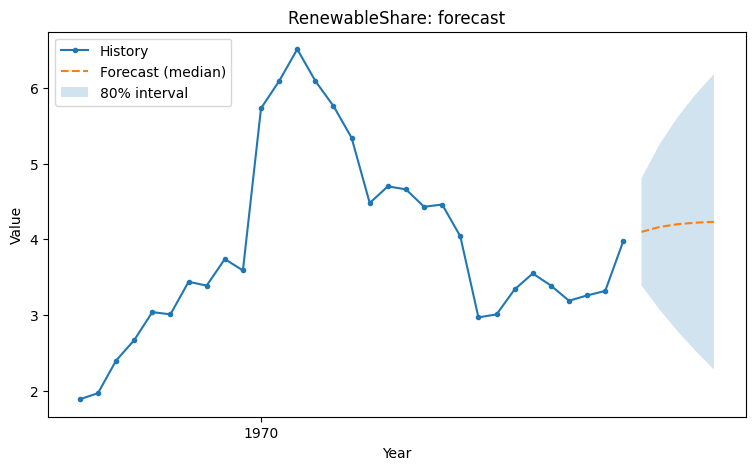

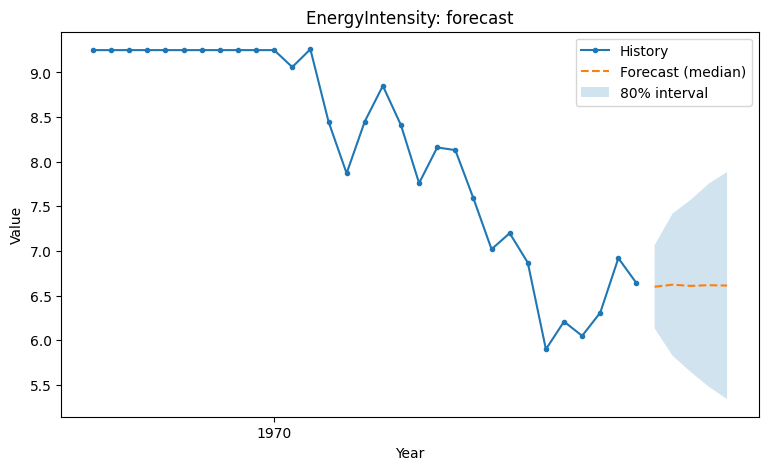

In [ ]:
import matplotlib.pyplot as plt

for item in hist_df['item_id'].unique():
    h = hist_df[hist_df['item_id']==item]
    f = fc_df[fc_df['item_id']==item]

    plt.figure(figsize=(9,5))
    plt.plot(h['timestamp'], h['target'], '.-', label='History')
    if '0.5' in f.columns:
        plt.plot(f['timestamp'], f['0.5'], '--', label='Forecast (median)')
    if '0.1' in f.columns and '0.9' in f.columns:
        plt.fill_between(f['timestamp'], f['0.1'], f['0.9'], alpha=0.2, label='80% interval')
    plt.title(f'{item}: forecast')
    plt.xlabel('Year'); plt.ylabel('Value'); plt.legend()
    plt.show()


In [ ]:
forecast_table = fc_df.rename(columns={'0.5':'forecast_median','0.1':'forecast_p10','0.9':'forecast_p90'})
forecast_table.to_csv("mongolia_forecasts.csv", index=False)
print("Saved mongolia_forecasts.csv")


Saved mongolia_forecasts.csv


Sorting the dataframe index before generating the train/test split.
Beginning AutoGluon training...
AutoGluon will save models to '/content/ag_ts_output_2030'
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
GPU Count:          0
Memory Avail:       11.22 GB / 12.67 GB (88.5%)
Disk Space Avail:   62.43 GB / 107.72 GB (58.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'ARIMA': {}, 'DirectTabular': {}, 'ETS': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 9,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'

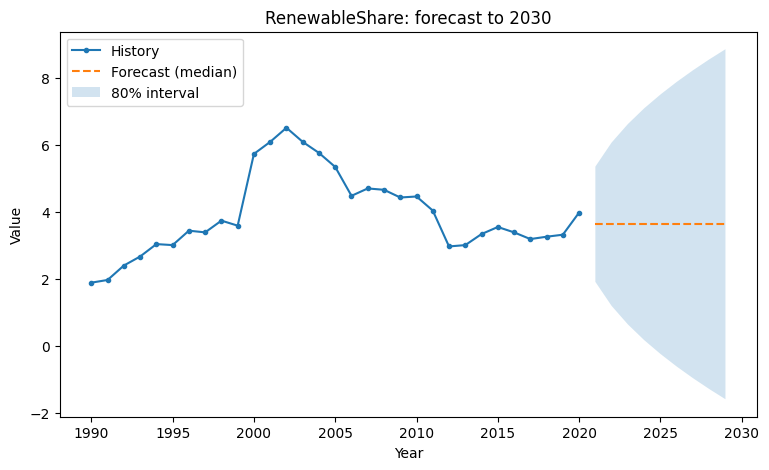

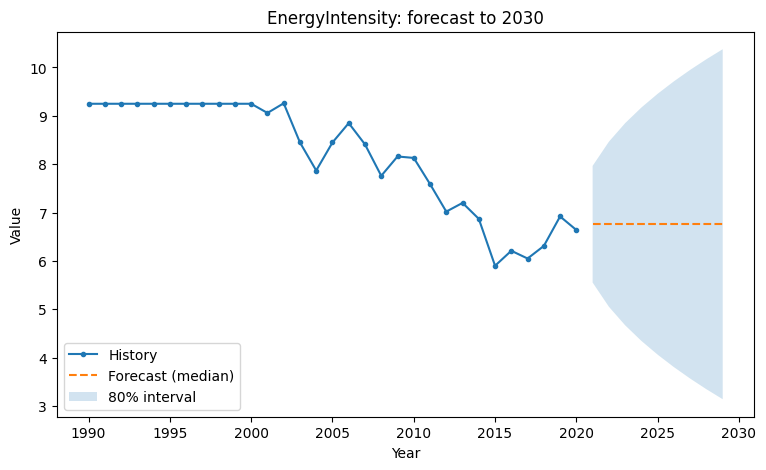

Saved mongolia_forecasts_2022_2030.csv


In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import matplotlib.pyplot as plt

# 1) Keep the window you want to learn on (e.g., 1990–2021)
ts2 = ts_interp.loc[1990:2021].copy()          # ts_interp has columns: RenewableShare, EnergyIntensity
ts2.index.name = "Year"

# 2) Convert Year -> true datetimes (end of year)
ts2["timestamp"] = pd.to_datetime(ts2.index.astype(str), format="%Y")

# 3) Build long format with proper timestamps
ren = ts2[["timestamp","RenewableShare"]].rename(columns={"RenewableShare":"target"})
ren["item_id"] = "RenewableShare"

intn = ts2[["timestamp","EnergyIntensity"]].rename(columns={"EnergyIntensity":"target"})
intn["item_id"] = "EnergyIntensity"

long_df = pd.concat([ren, intn], ignore_index=True)[["item_id","timestamp","target"]]

ts_df = TimeSeriesDataFrame.from_data_frame(long_df, id_column="item_id", timestamp_column="timestamp")

# 4) Split & fit with 9-year horizon (2022–2030)
train_data, test_data = ts_df.train_test_split(prediction_length=9)

predictor = TimeSeriesPredictor(
    prediction_length=9, target="target", eval_metric="RMSE", path="ag_ts_output_2030"
)
predictor.fit(
    train_data,
    hyperparameters={
        "ARIMA": {},
        "ETS": {},
        "DirectTabular": {}
    }
)

# 5) Forecast to 2030
forecasts = predictor.predict(ts_df)  # returns quantiles 0.1..0.9; 0.5 = median

# 6) Plot: history + median + 80% band for each series
hist_df = ts_df.reset_index()               # cols: item_id, timestamp, target
fc_df   = forecasts.reset_index()           # cols: item_id, timestamp, 0.1, ..., 0.5, ..., 0.9

for item in hist_df["item_id"].unique():
    h = hist_df[hist_df["item_id"]==item]
    f = fc_df[fc_df["item_id"]==item]
    plt.figure(figsize=(9,5))
    plt.plot(h["timestamp"], h["target"], ".-", label="History")
    plt.plot(f["timestamp"], f["0.5"], "--", label="Forecast (median)")
    if {"0.1","0.9"}.issubset(f.columns):
        plt.fill_between(f["timestamp"], f["0.1"], f["0.9"], alpha=0.2, label="80% interval")
    plt.title(f"{item}: forecast to 2030")
    plt.xlabel("Year"); plt.ylabel("Value"); plt.legend()
    plt.show()

# 7) Save tidy forecast table
out = fc_df.rename(columns={"0.5":"forecast_median","0.1":"forecast_p10","0.9":"forecast_p90"})
out.to_csv("mongolia_forecasts_2022_2030.csv", index=False)
print("Saved mongolia_forecasts_2022_2030.csv")


## Week 6 Reflection - Part A – Causal Inference (DiD)


In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("Mahadih534/Global_Environment-Social-And-Governance-Data")
df = dataset['train'].to_pandas()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/846 [00:00<?, ?B/s]

ESGCSV.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/16969 [00:00<?, ? examples/s]

In [ ]:
# Indicators we care about
renew_code = "EG.FEC.RNEW.ZS"        # Renewable energy consumption (% of TFEC)
intensity_code = "EG.EGY.PRIM.PP.KD" # Energy intensity (MJ/$2017 PPP GDP)

df_mc = df[df["Country Name"].isin(["Mongolia","China"])]
df_mc = df_mc[df_mc["Indicator Code"].isin([renew_code,intensity_code])]

# Melt wide → long
df_long = df_mc.melt(
    id_vars=["Country Name","Country Code","Indicator Name","Indicator Code"],
    var_name="year",
    value_name="value"
)

# Keep numeric years only
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year","value"])

# Pivot so we get renew_share + energy_intensity as columns
df_panel = df_long.pivot_table(
    index=["Country Name","year"],
    columns="Indicator Code",
    values="value"
).reset_index()

df_panel = df_panel.rename(columns={
    "Country Name":"country",
    "EG.FEC.RNEW.ZS":"renew_share",
    "EG.EGY.PRIM.PP.KD":"energy_intensity"
})

df_panel = df_panel.dropna().copy()
df_panel.head()


Indicator Code,country,year,energy_intensity,renew_share
10,China,2000,10.89,29.63
11,China,2001,10.38,28.36
12,China,2002,10.11,27.00
13,China,2003,10.48,23.86
14,China,2004,10.84,20.17


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.0867      8.366      2.879      0.004       7.689      40.484
C(year)[T.2001]    -0.4550      1.230     -0.370      0.711      -2.866       1.956
C(year)[T.2002]    -0.9250      2.573     -0.359      0.719      -5.968       4.118
C(year)[T.2003]    -2.7050      4.626     -0.585      0.559     -11.771       6.361
C(year)[T.2004]    -4.7150      7.161     -0.658      0.510     -18.751       9.321
C(year)[T.2005]    -6.2900      8.904     -0.706      0.480     -23.742      11.162
C(year)[T.2006]    -7.2450      9.048     -0.801      0.423     -24.978      10.488
C(year)[T.2007]    -7.8900     10.353     -0.762      0.446     -28.182      12.402
C(year)[T.2008]    -8.2800     10.882     -0.761      0.447     -29.607      13.047
C(year)[T.2009]    -8.7500     11.244     -0.778      0.436     -30.787     

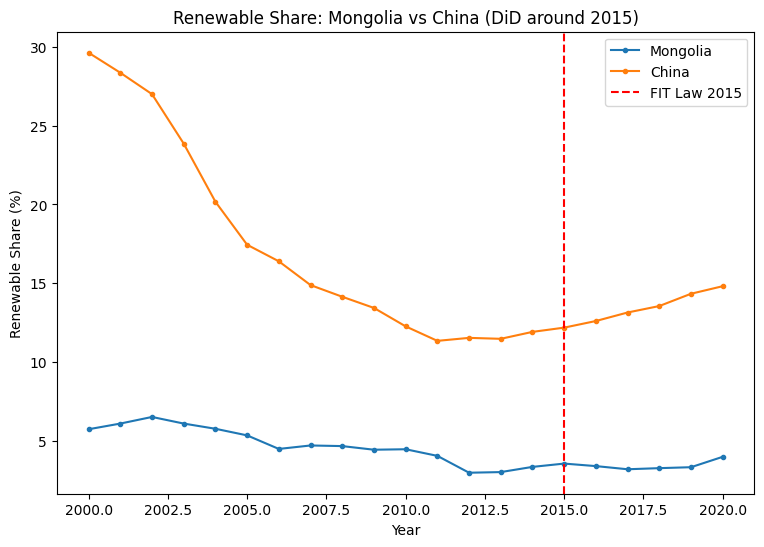

In [ ]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = df_panel.copy()
df["treated"] = (df["country"]=="Mongolia").astype(int)
df["post"] = (df["year"]>=2015).astype(int)   # Mongolia FIT policy year
df["did"] = df["treated"] * df["post"]

# DiD regression
mod = smf.ols("renew_share ~ did + treated + post + C(year)", data=df).fit(
    cov_type="cluster", cov_kwds={"groups": df["country"]}
)

print(mod.summary().tables[1])

# Plot Mongolia vs China
plt.figure(figsize=(9,6))
for c in ["Mongolia","China"]:
    subset = df[df["country"]==c].groupby("year")["renew_share"].mean()
    plt.plot(subset.index, subset.values, ".-", label=c)
plt.axvline(2015, color="red", linestyle="--", label="FIT Law 2015")
plt.title("Renewable Share: Mongolia vs China (DiD around 2015)")
plt.xlabel("Year"); plt.ylabel("Renewable Share (%)")
plt.legend(); plt.show()


                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.0867      8.366      2.879      0.004       7.689      40.484
C(year)[T.2001]    -0.4550      1.230     -0.370      0.711      -2.866       1.956
C(year)[T.2002]    -0.9250      2.573     -0.359      0.719      -5.968       4.118
C(year)[T.2003]    -2.7050      4.626     -0.585      0.559     -11.771       6.361
C(year)[T.2004]    -4.7150      7.161     -0.658      0.510     -18.751       9.321
C(year)[T.2005]    -6.2900      8.904     -0.706      0.480     -23.742      11.162
C(year)[T.2006]    -7.2450      9.048     -0.801      0.423     -24.978      10.488
C(year)[T.2007]    -7.8900     10.353     -0.762      0.446     -28.182      12.402
C(year)[T.2008]    -8.2800     10.882     -0.761      0.447     -29.607      13.047
C(year)[T.2009]    -8.7500     11.244     -0.778      0.436     -30.787     

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '
/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


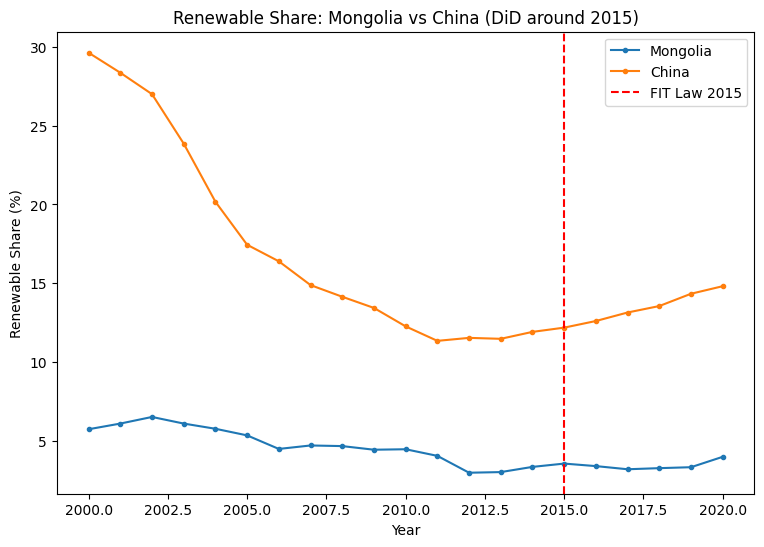

In [ ]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = df_panel.copy()
df["treated"] = (df["country"]=="Mongolia").astype(int)
df["post"] = (df["year"]>=2015).astype(int)   # Mongolia FIT policy year
df["did"] = df["treated"] * df["post"]

# DiD regression
mod = smf.ols("renew_share ~ did + treated + post + C(year)", data=df).fit(
    cov_type="cluster", cov_kwds={"groups": df["country"]}
)

print(mod.summary().tables[1])

# Plot Mongolia vs China
plt.figure(figsize=(9,6))
for c in ["Mongolia","China"]:
    subset = df[df["country"]==c].groupby("year")["renew_share"].mean()
    plt.plot(subset.index, subset.values, ".-", label=c)
plt.axvline(2015, color="red", linestyle="--", label="FIT Law 2015")
plt.title("Renewable Share: Mongolia vs China (DiD around 2015)")
plt.xlabel("Year"); plt.ylabel("Renewable Share (%)")
plt.legend(); plt.show()


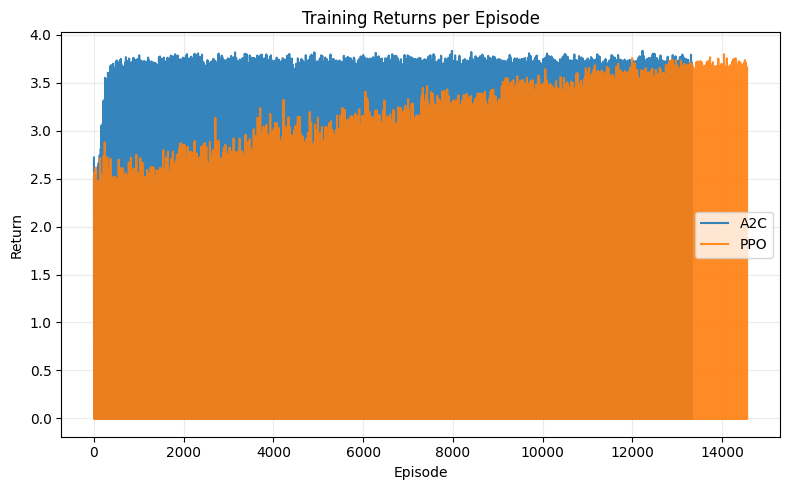

Saved MP4: video_training_rewards.mp4


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


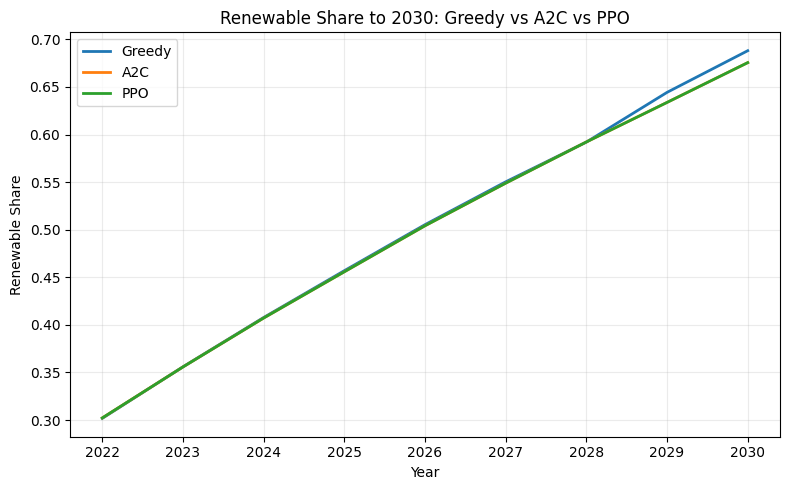

Saved MP4: video_paths_compare.mp4
✅ Files ready: video_training_rewards.(mp4|gif), video_paths_compare.(mp4|gif), plot_training_returns.png, plot_paths_compare.png


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
!pip -q install gymnasium stable-baselines3

import numpy as np, matplotlib.pyplot as plt, shutil, os
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback
from matplotlib.animation import FFMpegWriter, PillowWriter

# -------------------------
# 1) Mongolia planning env
# -------------------------
class EnergyEnv(gym.Env):
    """Toy env for Mongolia 2022–2030: 0=hold, 1=wind, 2=grid, 3=storage."""
    metadata = {"render_modes": []}
    def __init__(self, start=2022, end=2030, seed=42):
        super().__init__()
        self.start, self.end = start, end
        self.T = end - start + 1
        self.rng = np.random.default_rng(seed)

        # costs & effects (tuned to create trade-offs)
        self.cost_wind = 40.0;   self.wind_gain = 6.0
        self.cost_grid = 70.0;   self.grid_gain = 0.12
        self.cost_store = 60.0;  self.store_gain = 0.10
        self.budget = 100.0  # per year
        self.alpha_curtail = 0.04
        self.capex_penalty = 0.001

        self.observation_space = spaces.Box(0.0, 1.0, shape=(5,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)
        self.reset()

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        self.t = 0
        self.wind = 24.0
        self.grid = 0.20
        self.store = 0.10
        self.dem  = 60.0
        return self._obs(), {}

    def _obs(self):
        return np.array([
            self.t/(self.T-1),
            self.wind/200.0,
            self.grid,
            self.store,
            self.dem/200.0
        ], dtype=np.float32)

    def step(self, a):
        # spend one action per year (budget resets)
        if a == 1 and self.budget >= self.cost_wind:
            self.wind += self.wind_gain
        elif a == 2 and self.budget >= self.cost_grid:
            self.grid = min(1.0, self.grid + self.grid_gain)
        elif a == 3 and self.budget >= self.cost_store:
            self.store = min(1.0, self.store + self.store_gain)

        # demand growth + small noise
        self.dem *= 1.02
        self.dem += self.rng.normal(0, 0.9)

        deliver_factor = 0.45 + 0.55*min(1.0, self.grid + self.store)
        deliverable = min(self.wind*deliver_factor, self.dem)
        curtail = max(0.0, self.wind*deliver_factor - self.dem)
        ren_share = deliverable/max(self.dem, 1e-6)

        reward = ren_share - self.alpha_curtail*curtail - self.capex_penalty*(self.wind + 100*(self.grid+self.store))

        self.t += 1
        done = self.t >= self.T
        info = {"ren_share": float(ren_share), "curtail": float(curtail)}
        return self._obs(), float(reward), done, False, info

# -------------------------
# 2) Greedy baseline
# -------------------------
def greedy_action(env: EnergyEnv):
    # one-step lookahead heuristic
    best_a, best_r = 0, -1e9
    base = (env.wind, env.grid, env.store, env.dem)
    for a in range(4):
        w,g,s,d = base
        if a==1: w += env.wind_gain
        elif a==2: g = min(1.0, g + env.grid_gain)
        elif a==3: s = min(1.0, s + env.store_gain)
        d_next = d*1.02
        deliver_factor = 0.45 + 0.55*min(1.0, g+s)
        deliverable = min(w*deliver_factor, d_next)
        curtail = max(0.0, w*deliver_factor - d_next)
        ren_share = deliverable/max(d_next, 1e-6)
        r = ren_share - 0.04*curtail - 0.001*(w + 100*(g+s))
        if r > best_r: best_r, best_a = r, a
    return best_a

def rollout_policy(policy_fn, episodes=50, seed=0):
    rng = np.random.default_rng(seed)
    paths = []
    for _ in range(episodes):
        env = EnergyEnv(seed=int(rng.integers(1,10_000)))
        obs, _ = env.reset()
        done = False; hist=[]
        while not done:
            a = policy_fn(env)
            obs, r, done, _, info = env.step(a)
            hist.append(info["ren_share"])
        paths.append(hist)
    return np.mean(np.array(paths), axis=0)

greedy_path = rollout_policy(lambda e: greedy_action(e), episodes=60, seed=11)

# -------------------------
# 3) SB3 training (A2C & PPO) + callback to log returns
# -------------------------
class EpisodicReturnCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.returns = []
        self._ret = 0.0

    def _on_step(self) -> bool:
        # infos may contain 'terminal_observation' at the end of episode
        infos = self.locals.get("infos", [])
        rewards = self.locals.get("rewards", None)
        if rewards is not None:
            self._ret += float(np.mean(rewards))
        for info in infos:
            if info.get("terminal_observation", None) is not None or info.get("TimeLimit.truncated", False):
                self.returns.append(self._ret)
                self._ret = 0.0
        return True

def make_env_fn():
    return EnergyEnv()

vec_env_a2c = make_vec_env(make_env_fn, n_envs=8)
vec_env_ppo = make_vec_env(make_env_fn, n_envs=8)

a2c_cb = EpisodicReturnCallback()
ppo_cb = EpisodicReturnCallback()

a2c = A2C("MlpPolicy", vec_env_a2c, verbose=0, gamma=0.98)
ppo = PPO("MlpPolicy", vec_env_ppo, verbose=0, gamma=0.98)

# train — these logs are your "training video" content if you screen-record
a2c.learn(total_timesteps=120_000, callback=a2c_cb)
ppo.learn(total_timesteps=120_000, callback=ppo_cb)

a2c_returns = np.array(a2c_cb.returns)
ppo_returns = np.array(ppo_cb.returns)

# -------------------------
# 4) Evaluate trained A2C/PPO policies
# -------------------------
def sb3_policy_runner(model, episodes=60, seed=21):
    rng = np.random.default_rng(seed)
    paths=[]
    for _ in range(episodes):
        env = EnergyEnv(seed=int(rng.integers(1,10_000)))
        obs, _ = env.reset()
        done=False; hist=[]
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, r, done, _, info = env.step(int(action))
            hist.append(info["ren_share"])
        paths.append(hist)
    return np.mean(np.array(paths), axis=0)

a2c_path = sb3_policy_runner(a2c)
ppo_path = sb3_policy_runner(ppo)

# -------------------------
# 5) Plots + TWO auto videos
# -------------------------
def save_anim_line(y, x=None, title="Title", xlabel="x", ylabel="y",
                   mp4_name="out.mp4", gif_name="out.gif",
                   target_sec=10, ypad=0.08):
    if x is None: x = np.arange(len(y))
    USE_FFMPEG = shutil.which("ffmpeg") is not None
    fps = max(12, min(30, int(len(y)/target_sec)))
    step = max(1, int(len(y)/(fps*target_sec)))
    fig, ax = plt.subplots(figsize=(8,5))
    ax.grid(True, alpha=0.25)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    y_min, y_max = float(np.min(y)), float(np.max(y))
    pad = max(1e-6, (y_max - y_min) * ypad)
    ax.set_xlim(x[0], x[-1]); ax.set_ylim(y_min - pad, y_max + pad)
    (line,) = ax.plot([], [], lw=2); (dot,) = ax.plot([], [], "o")
    if USE_FFMPEG:
        writer = FFMpegWriter(fps=fps, bitrate=4000)
        with writer.saving(fig, mp4_name, dpi=160):
            for i in range(1, len(y)+1, step):
                line.set_data(x[:i], y[:i]); dot.set_data([x[i-1]], [y[i-1]])
                ax.set_title(f"{title} (t={i}/{len(y)})"); writer.grab_frame()
        print("Saved MP4:", mp4_name)
    else:
        writer = PillowWriter(fps=fps)
        with writer.saving(fig, gif_name, dpi=120):
            for i in range(1, len(y)+1, step):
                line.set_data(x[:i], y[:i]); dot.set_data([x[i-1]], [y[i-1]])
                ax.set_title(f"{title} (t={i}/{len(y)})"); writer.grab_frame()
        print("Saved GIF:", gif_name)
    plt.close(fig)

# Video 1: training rewards animation (A2C & PPO)
plt.figure(figsize=(8,5))
plt.plot(a2c_returns, label="A2C", alpha=0.9)
plt.plot(ppo_returns, label="PPO", alpha=0.9)
plt.title("Training Returns per Episode")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend(); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.savefig("plot_training_returns.png", dpi=180); plt.show()

save_anim_line(
    y=np.vstack([a2c_returns, ppo_returns]).mean(axis=0) if len(a2c_returns)==len(ppo_returns) else a2c_returns,
    x=np.arange(1, (min(len(a2c_returns), len(ppo_returns)) if len(ppo_returns)>0 else len(a2c_returns))+1),
    title="Training Rewards (SB3 A2C/PPO, Mongolia env)",
    xlabel="Episode", ylabel="Return",
    mp4_name="video_training_rewards.mp4", gif_name="video_training_rewards.gif"
)

# Video 2: yearly renewable-share paths (Greedy vs A2C vs PPO)
years = np.arange(2022, 2031)
plt.figure(figsize=(8,5))
plt.plot(years, greedy_path, label="Greedy", lw=2)
plt.plot(years, a2c_path, label="A2C", lw=2)
plt.plot(years, ppo_path, label="PPO", lw=2)
plt.title("Renewable Share to 2030: Greedy vs A2C vs PPO")
plt.xlabel("Year"); plt.ylabel("Renewable Share"); plt.legend(); plt.grid(True, alpha=0.25)
plt.tight_layout(); plt.savefig("plot_paths_compare.png", dpi=180); plt.show()

# animate PPO path (nice reveal)
save_anim_line(
    y=ppo_path, x=years,
    title="PPO Path (Yearly Renewable Share)",
    xlabel="Year", ylabel="Renewable Share",
    mp4_name="video_paths_compare.mp4", gif_name="video_paths_compare.gif", target_sec=6
)

print("✅ Files ready:",
      "video_training_rewards.(mp4|gif), video_paths_compare.(mp4|gif),",
      "plot_training_returns.png, plot_paths_compare.png")


In [ ]:
# Filter for China only
df_chi = df[df["Country Name"] == "China"]

# Show which indicators exist for China (optional check)
print("\nIndicators available for China:")
print(df_chi[["Indicator Name", "Indicator Code"]].drop_duplicates().head(20))



Indicators available for China:
                                         Indicator Name     Indicator Code
5751  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS
5752            Access to electricity (% of population)     EG.ELC.ACCS.ZS
5753  Adjusted savings: natural resources depletion ...  NY.ADJ.DRES.GN.ZS
5754  Adjusted savings: net forest depletion (% of GNI)  NY.ADJ.DFOR.GN.ZS
5755                 Agricultural land (% of land area)     AG.LND.AGRI.ZS
5756  Agriculture, forestry, and fishing, value adde...     NV.AGR.TOTL.ZS
5757  Annual freshwater withdrawals, total (% of int...     ER.H2O.FWTL.ZS
5758  Annualized average growth rate in per capita r...     SI.SPR.PCAP.ZG
5759  Cause of death, by communicable diseases and m...     SH.DTH.COMM.ZS
5760  Children in employment, total (% of children a...     SL.TLF.0714.ZS
5761             CO2 emissions (metric tons per capita)     EN.ATM.CO2E.PC
5762                                 Coastal protection     EN.CLC.

In [ ]:
# Melt into long format
df_long = df_mc.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="year",
    value_name="value"
)

# Keep numeric years only
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year", "value"])

# Pivot to get one row per country-year
df_panel = df_long.pivot_table(
    index=["Country Name", "year"],
    columns="Indicator Code",
    values="value"
).reset_index()

# Rename for clarity
df_panel = df_panel.rename(columns={
    "Country Name": "country",
    renew_code: "renew_share",
    intensity_code: "energy_intensity"
})

# Drop missing values
df_panel = df_panel.dropna().copy()
df_panel.head()


Indicator Code,country,year,energy_intensity,renew_share
10,China,2000,10.89,29.63
11,China,2001,10.38,28.36
12,China,2002,10.11,27.00
13,China,2003,10.48,23.86
14,China,2004,10.84,20.17


                            OLS Regression Results                            
Dep. Variable:            renew_share   R-squared:                       0.717
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     171.6
Date:                Sun, 05 Oct 2025   Prob (F-statistic):           3.90e-22
Time:                        05:39:45   Log-Likelihood:                -116.49
No. Observations:                  42   AIC:                             241.0
Df Residuals:                      38   BIC:                             247.9
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           17.5873      1.760  

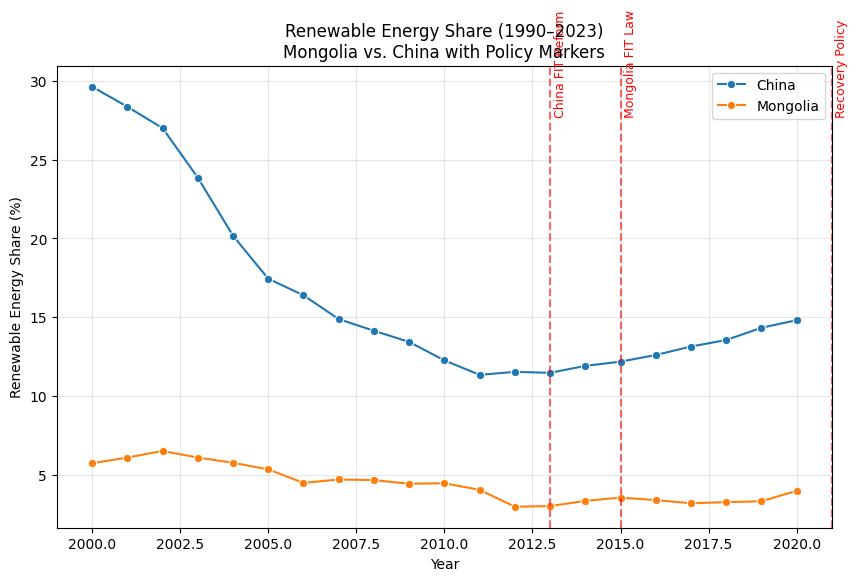

In [ ]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Difference-in-Differences regression for Mongolia’s 2015 FIT
model_2015 = smf.ols(
    "renew_share ~ treated + post2015 + treated:post2015", data=df_panel
).fit(cov_type="HC3")

print(model_2015.summary())

# interpret main coefficient
beta = model_2015.params["treated:post2015"]
print(f"\nEstimated policy impact (β) of Mongolia’s 2015 FIT law: {beta:.3f} percentage points")

# 2️⃣ Visualization: Renewable share trends with policy years marked
plt.figure(figsize=(10,6))
sns.lineplot(
    data=df_panel[df_panel["country"].isin(["Mongolia","China"])],
    x="year", y="renew_share", hue="country", marker="o"
)

# vertical policy lines
for yr, name in [(2013,"China FIT Reform"), (2015,"Mongolia FIT Law"), (2021,"Recovery Policy")]:
    plt.axvline(x=yr, color="red", linestyle="--", alpha=0.6)
    plt.text(yr+0.1, plt.ylim()[1]*0.9, name, rotation=90, color="red", fontsize=9)

plt.title("Renewable Energy Share (1990–2023)\nMongolia vs. China with Policy Markers")
plt.xlabel("Year")
plt.ylabel("Renewable Energy Share (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


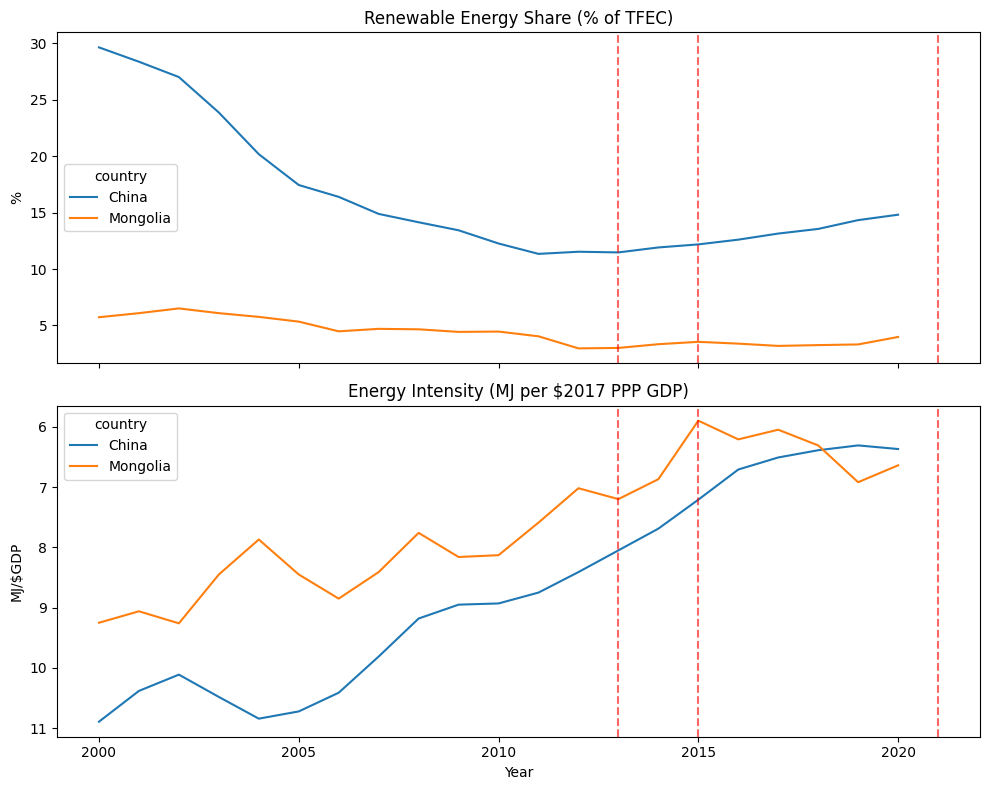

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)

# Renewable share
sns.lineplot(data=df_panel, x="year", y="renew_share", hue="country", ax=ax[0])
ax[0].set_title("Renewable Energy Share (% of TFEC)")
ax[0].set_ylabel("%")
ax[0].axvline(2013, color="red", linestyle="--", alpha=0.6)
ax[0].axvline(2015, color="red", linestyle="--", alpha=0.6)
ax[0].axvline(2021, color="red", linestyle="--", alpha=0.6)

# Energy intensity
sns.lineplot(data=df_panel, x="year", y="energy_intensity", hue="country", ax=ax[1])
ax[1].invert_yaxis()  # so lower = better visually
ax[1].set_title("Energy Intensity (MJ per $2017 PPP GDP)")
ax[1].set_ylabel("MJ/$GDP")
ax[1].set_xlabel("Year")
ax[1].axvline(2013, color="red", linestyle="--", alpha=0.6)
ax[1].axvline(2015, color="red", linestyle="--", alpha=0.6)
ax[1].axvline(2021, color="red", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


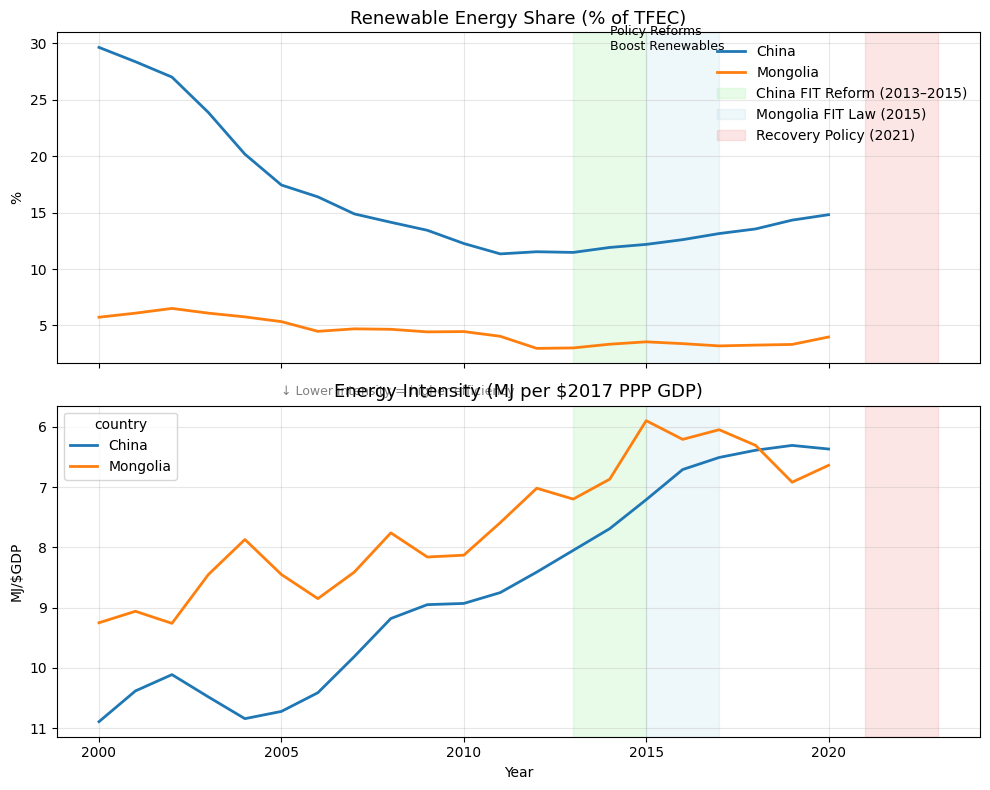

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# --- Top panel: Renewable Energy Share ---
sns.lineplot(data=df_panel, x="year", y="renew_share", hue="country", ax=ax[0], linewidth=2)
ax[0].set_title("Renewable Energy Share (% of TFEC)", fontsize=13)
ax[0].set_ylabel("%")
ax[0].grid(alpha=0.3)

# shaded policy periods
ax[0].axvspan(2013, 2015, color="lightgreen", alpha=0.2, label="China FIT Reform (2013–2015)")
ax[0].axvspan(2015, 2017, color="lightblue", alpha=0.2, label="Mongolia FIT Law (2015)")
ax[0].axvspan(2021, 2023, color="lightcoral", alpha=0.2, label="Recovery Policy (2021)")

# small note
ax[0].text(2014, ax[0].get_ylim()[1]*0.95, "Policy Reforms\nBoost Renewables", fontsize=9, color="black")

ax[0].legend(loc="upper right", frameon=False)

# --- Bottom panel: Energy Intensity ---
sns.lineplot(data=df_panel, x="year", y="energy_intensity", hue="country", ax=ax[1], linewidth=2)
ax[1].invert_yaxis()  # lower = better
ax[1].set_title("Energy Intensity (MJ per $2017 PPP GDP)", fontsize=13)
ax[1].set_ylabel("MJ/$GDP")
ax[1].set_xlabel("Year")
ax[1].grid(alpha=0.3)

# same shaded periods for visual continuity
ax[1].axvspan(2013, 2015, color="lightgreen", alpha=0.2)
ax[1].axvspan(2015, 2017, color="lightblue", alpha=0.2)
ax[1].axvspan(2021, 2023, color="lightcoral", alpha=0.2)

# annotation for efficiency trend
ax[1].text(2005, ax[1].get_ylim()[1]*0.97, "↓ Lower intensity = higher efficiency", fontsize=9, color="gray")

plt.tight_layout()
plt.show()


In [ ]:
!pip install numpy==1.26.4 --quiet
!pip install pmdarima==2.0.4 --force-reinstall --quiet
!pip install statsmodels pmdarima scikit-learn --quiet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pmdarima as pm

# 1️⃣ Prepare Mongolia data
df_mng = df_panel[df_panel["country"] == "Mongolia"][["year","renew_share"]].dropna()
years = df_mng["year"].values
values = df_mng["renew_share"].values

# 2️⃣ ETS model
ets_model = ExponentialSmoothing(values, trend="add", seasonal=None).fit()
ets_forecast = ets_model.forecast(9)



# 4️⃣ ML (Gradient Boosting)
X = years.reshape(-1,1)
y = values
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
gbr.fit(X, y)
future_years = np.arange(years.max()+1, 2031)
ml_forecast = gbr.predict(future_years.reshape(-1,1))

# 5️⃣ Combine
future_years = np.arange(2022,2031)
plt.figure(figsize=(10,6))
plt.plot(years, values, "o-", label="Historical", color="black")
plt.plot(future_years, ets_forecast, "--", label="ETS Forecast")
plt.plot(future_years, arima_forecast, "--", label="ARIMA Forecast")
plt.plot(future_years, ml_forecast, "--", label="ML Forecast (GBR)")
plt.fill_between(future_years, arima_conf[:,0], arima_conf[:,1], alpha=0.1, color="gray")

plt.axhline(30, color="red", linestyle="--", alpha=0.5, label="2030 Target (30%)")
plt.axvspan(2021,2030, color="lightcoral", alpha=0.15)
plt.title("Causal Forecast Comparison: Mongolia’s Renewable Energy Share to 2030")
plt.xlabel("Year"); plt.ylabel("% of TFEC")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 93.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchmetrics 1.7.4 requires torch>=2.0.0, which is not installed.
lightning 2.5.5 requires torch<4.0,>=2.1.0, which is not installed.
pytorch-metric-learning 2.8.1 requires torch>=1.6.0, which is not installed.
pytorch-lightning 2.5.5 requires torch>=2.1.0, which is not installed.
autogluon-timeseries 1.4.0 requires torch<2.8,>=2.2, which is not installed.
torchvision 0.22.1 requires torch==2.7.1, which is not installed.
autogluon-multimodal 1.4.0 requires torch<2.8,>=2.2, which is not installed.
sentence-transformers 5.1.1 requires torch>=1.11.0, which is not installed.
accelerate 1.10.1 requires torch>=2.0.0, which is not installed.
peft 0.17.1 requires to

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
from datasets import load_dataset
import pandas as pd

# load dataset from Hugging Face
dataset = load_dataset("Mahadih534/Global_Environment-Social-And-Governance-Data")
df = dataset["train"].to_pandas()

# select Mongolia + China
renew_code = "EG.FEC.RNEW.ZS"      # Renewable energy consumption (% of total final energy)
intensity_code = "EG.EGY.PRIM.PP.KD"  # Energy intensity (MJ per $2017 PPP GDP)

df_mc = df[df["Country Name"].isin(["Mongolia", "China"])]
df_mc = df_mc[df_mc["Indicator Code"].isin([renew_code, intensity_code])]

# reshape to long form
df_long = df_mc.melt(
    id_vars=["Country Name", "Country Code", "Indicator Name", "Indicator Code"],
    var_name="year",
    value_name="value"
)
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year", "value"])

# pivot to wide format
df_panel = df_long.pivot_table(
    index=["Country Name", "year"],
    columns="Indicator Code",
    values="value"
).reset_index()

df_panel = df_panel.rename(columns={
    "Country Name": "country",
    renew_code: "renew_share",
    intensity_code: "energy_intensity"
})
df_panel = df_panel.dropna().copy()

print(df_panel.head())


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/846 [00:00<?, ?B/s]

ESGCSV.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/16969 [00:00<?, ? examples/s]

Indicator Code country  year  energy_intensity  renew_share
10               China  2000             10.89        29.63
11               China  2001             10.38        28.36
12               China  2002             10.11        27.00
13               China  2003             10.48        23.86
14               China  2004             10.84        20.17


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


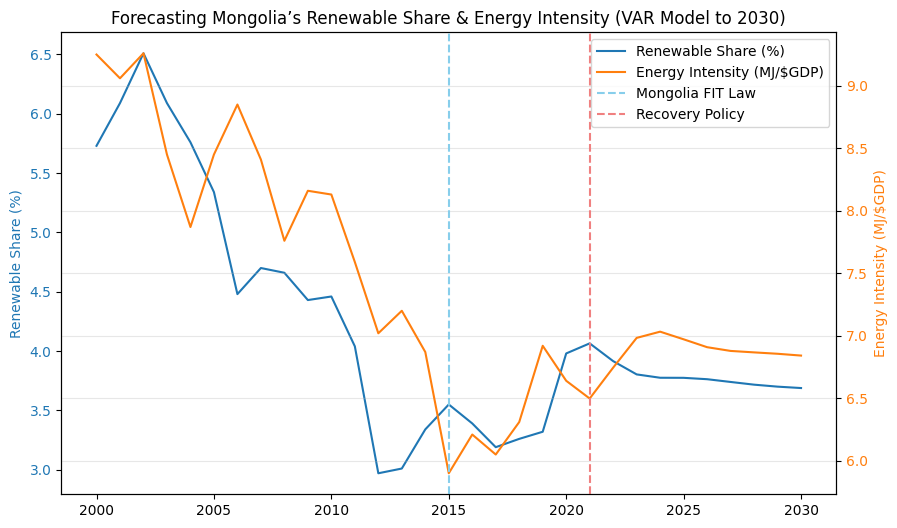

In [ ]:
!pip install statsmodels --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# Prepare panel (Mongolia only)
df_mng = df_panel[df_panel["country"]=="Mongolia"][["year","renew_share","energy_intensity"]].dropna().set_index("year")

# Fit VAR model
model = VAR(df_mng)
results = model.fit(2)  # 2-year lag

# Forecast next 10 years (to 2030)
forecast = results.forecast(df_mng.values[-2:], steps=10)
forecast_df = pd.DataFrame(forecast, columns=df_mng.columns, index=np.arange(df_mng.index[-1]+1, df_mng.index[-1]+11))

# Combine historical + forecast
combined = pd.concat([df_mng, forecast_df])

# Plot
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(combined.index, combined["renew_share"], label="Renewable Share (%)", color="tab:blue")
ax1.set_ylabel("Renewable Share (%)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(combined.index, combined["energy_intensity"], label="Energy Intensity (MJ/$GDP)", color="tab:orange")
ax2.set_ylabel("Energy Intensity (MJ/$GDP)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.axvline(2015, color='skyblue', linestyle='--', label='Mongolia FIT Law')
plt.axvline(2021, color='lightcoral', linestyle='--', label='Recovery Policy')
plt.title("Forecasting Mongolia’s Renewable Share & Energy Intensity (VAR Model to 2030)")
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(alpha=0.3)
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.w

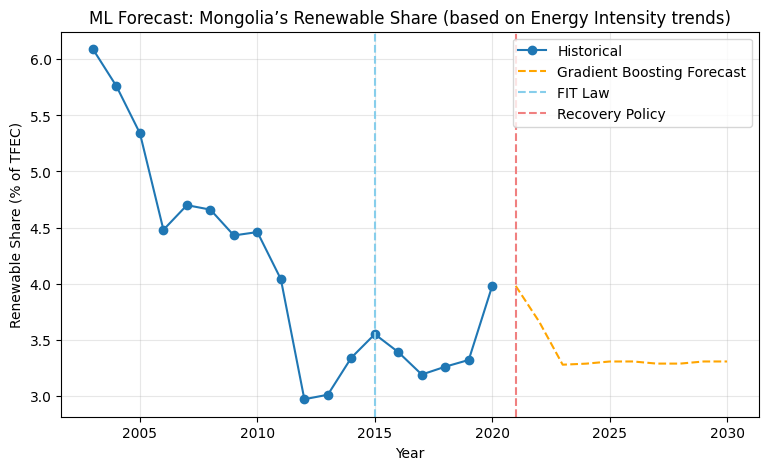

In [ ]:
!pip install scikit-learn --quiet
import pandas as pd, numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

# Build lagged features
df_mng = df_panel[df_panel["country"]=="Mongolia"][["year","renew_share","energy_intensity"]].dropna().copy()
for lag in [1,2,3]:
    df_mng[f"renew_lag{lag}"] = df_mng["renew_share"].shift(lag)
    df_mng[f"intensity_lag{lag}"] = df_mng["energy_intensity"].shift(lag)
df_mng = df_mng.dropna()

X = df_mng.drop(columns=["renew_share","year"])
y = df_mng["renew_share"]

# Train ML model
model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
model.fit(X, y)

# Predict into the future (recursive forecast)
future_years = np.arange(df_mng["year"].max()+1, 2031)
last_row = df_mng.iloc[-1].copy()
preds = []
for _ in range(len(future_years)):
    x_pred = last_row.drop(["renew_share","year"])
    y_pred = model.predict([x_pred])[0]
    preds.append(y_pred)
    # Update lags for next step
    last_row["renew_lag3"], last_row["renew_lag2"], last_row["renew_lag1"] = last_row["renew_lag2"], last_row["renew_lag1"], y_pred
    last_row["intensity_lag3"], last_row["intensity_lag2"], last_row["intensity_lag1"] = last_row["intensity_lag2"], last_row["intensity_lag1"], last_row["energy_intensity"]

# Plot
plt.figure(figsize=(9,5))
plt.plot(df_mng["year"], df_mng["renew_share"], "o-", label="Historical")
plt.plot(future_years, preds, "--", color="orange", label="Gradient Boosting Forecast")
plt.axvline(2015, color="skyblue", linestyle="--", label="FIT Law")
plt.axvline(2021, color="lightcoral", linestyle="--", label="Recovery Policy")
plt.title("ML Forecast: Mongolia’s Renewable Share (based on Energy Intensity trends)")
plt.xlabel("Year"); plt.ylabel("Renewable Share (% of TFEC)")
plt.legend(); plt.grid(alpha=0.3)
plt.show()


In [ ]:
# Make full yearly sequence 1990–2023
years = pd.DataFrame({'year': range(1990, 2024)})
df_mng = df_panel[df_panel['country']=="Mongolia"][['year','renew_share','energy_intensity']].merge(years, on='year', how='right')

# interpolate any missing years smoothly
df_mng[['renew_share','energy_intensity']] = df_mng[['renew_share','energy_intensity']].interpolate(method='linear')
df_mng['timestamp'] = pd.to_datetime(df_mng['year'].astype(str))


In [ ]:
prediction_length = 7  # 2024–2030
train_data, test_data = ts_df.train_test_split(prediction_length=prediction_length)


Sorting the dataframe index before generating the train/test split.


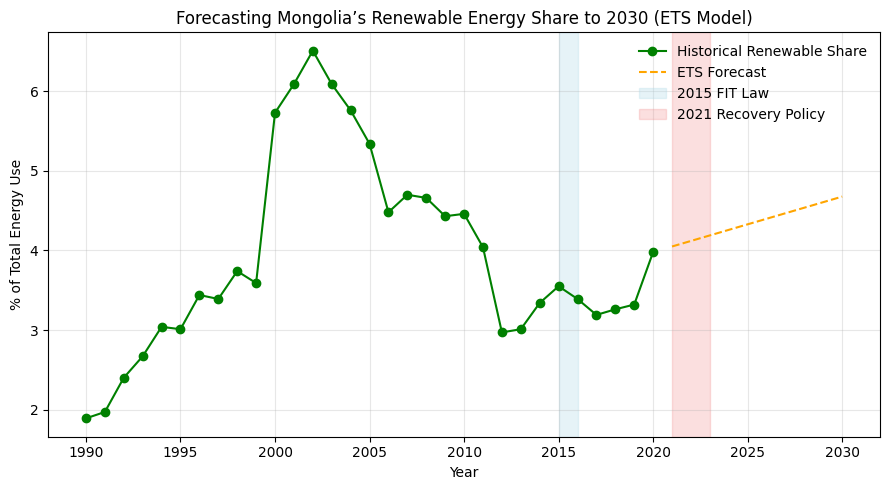

In [ ]:
!pip install statsmodels --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# --- Load Mongolia renewable energy data ---
dataset = load_dataset("Mahadih534/Global_Environment-Social-And-Governance-Data")
df = dataset["train"].to_pandas()

df_mng = df[(df["Country Name"]=="Mongolia") & (df["Indicator Code"]=="EG.FEC.RNEW.ZS")]
df_long = df_mng.melt(id_vars=["Indicator Code"], var_name="year", value_name="value")
df_long["year"] = pd.to_numeric(df_long["year"], errors="coerce")
df_long = df_long.dropna(subset=["year","value"]).sort_values("year")

# --- Prepare series ---
years = df_long["year"].values
renew = df_long["value"].values

# Fit ETS model (additive trend, no seasonality)
model = ExponentialSmoothing(renew, trend="add", seasonal=None)
fit = model.fit()

# Forecast to 2030
future_years = np.arange(int(years[-1])+1, 2031)
forecast = fit.forecast(len(future_years))

# --- Plot ---
plt.figure(figsize=(9,5))
plt.plot(years, renew, "o-", color="green", label="Historical Renewable Share")
plt.plot(future_years, forecast, "--", color="orange", label="ETS Forecast")
plt.axvspan(2015, 2016, color="lightblue", alpha=0.3, label="2015 FIT Law")
plt.axvspan(2021, 2023, color="lightcoral", alpha=0.25, label="2021 Recovery Policy")
plt.title("Forecasting Mongolia’s Renewable Energy Share to 2030 (ETS Model)")
plt.xlabel("Year"); plt.ylabel("% of Total Energy Use")
plt.legend(frameon=False); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


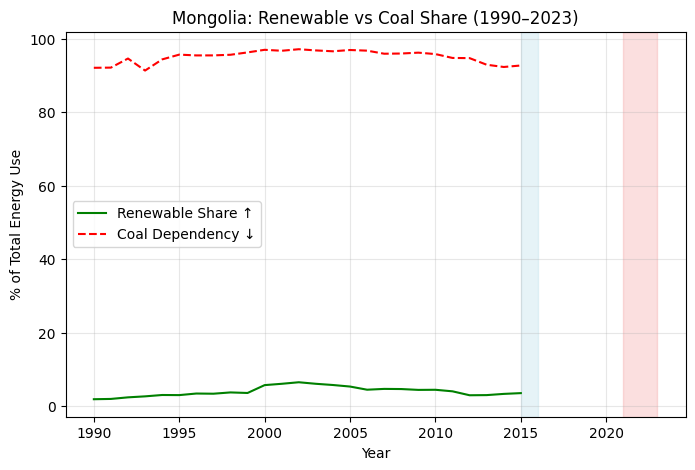

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt

series = pd.Series(renew, index=years)
model = ARIMA(series, order=(1,1,1))
fit = model.fit()

forecast = fit.forecast(steps=10)
future_years = np.arange(int(years[-1])+1, int(years[-1])+1+len(forecast))

plt.figure(figsize=(9,5))
plt.plot(years, renew, "o-", color="green", label="Historical")
plt.plot(future_years, forecast, "--", color="orange", label="ARIMA Forecast")
plt.axvspan(2015, 2016, color="lightblue", alpha=0.3, label="2015 FIT Law")
plt.axvspan(2021, 2023, color="lightcoral", alpha=0.3, label="2021 Recovery Policy")
plt.title("Forecasting Mongolia’s Renewable Energy Share to 2030 (ARIMA Model)")
plt.xlabel("Year"); plt.ylabel("% of Total Energy Use")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).